In [90]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [91]:
resolution = '10km'
file = f'data/{resolution}_data.csv'

data = pd.read_csv(file)
Xraw = np.array(data[['lat', 'long']])
Yraw = np.array(data['generated_temp']).reshape(-1,1)
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [92]:
true_alt, true_temps = get_alt_temp_grids(data)

In [93]:
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1, 
                    'show_plot'   : True,
                }
}

cause_cluster_params =  {'model' : 'KMeans',
                        'model_params' : {'n_clusters' : 3000},
                        'verbose' : 0
}

In [94]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'running1' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to running1\experiment0010
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2000
149/149 [==============================] - 0s 2ms/step - loss: 1.0101 - val_loss: 0.9753
Epoch 2/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9765 - val_loss: 0.9519
Epoch 3/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9548 - val_loss: 0.9352
Epoch 4/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9378 - val_loss: 0.9209
Epoch 5/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9230 - val_loss: 0.9081
Epoch 6/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9098 - val_loss: 0.8964
Epoch 7/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8977 - val_loss: 0.8854
Epoch 8/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8864 - val_loss: 0.8753
Epoch 9/2000
149/149 [==================

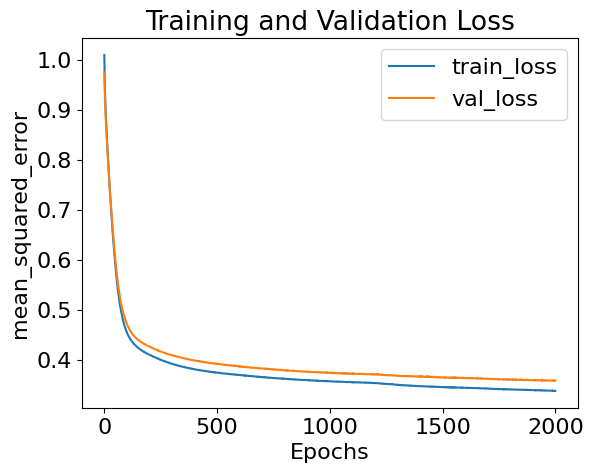

397/397 [==============================] - 0s 554us/step
Loading parameters from  tmp_checkpoints27012025161210\best_weights
Saving parameters to  running1\experiment0010\trained_blocks\CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [95]:
results = my_exp.train()

MAX ELEVATION FOR THIS DATASET: 1792.459


<Figure size 1200x600 with 0 Axes>

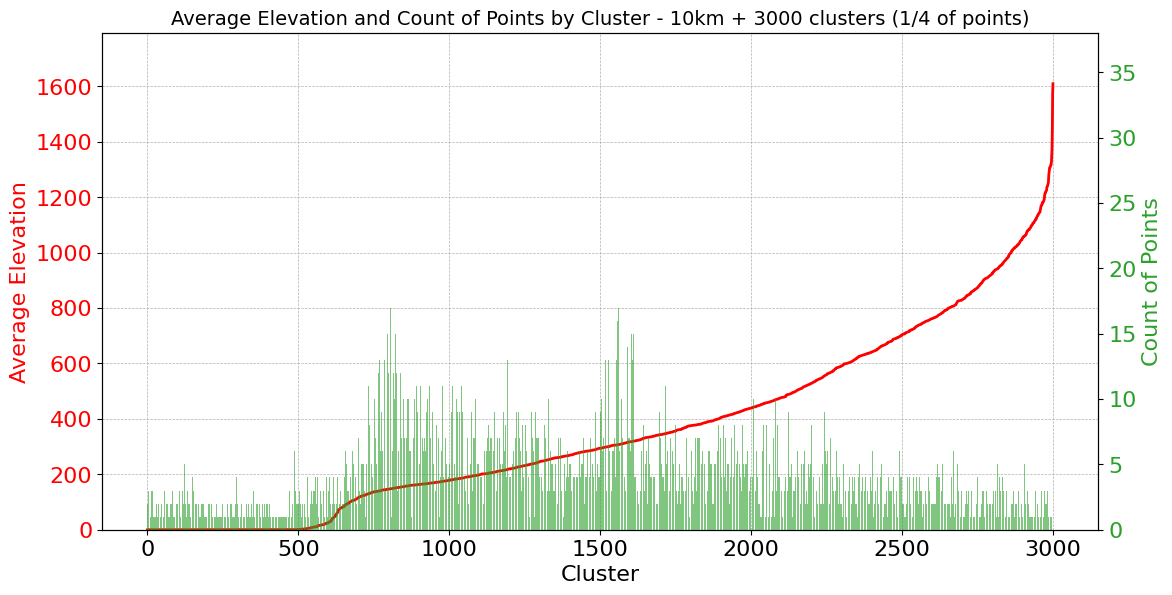

In [96]:
import matplotlib.pyplot as plt

xlbls = results['CauseClusterer']['x_lbls']

avgs, lbl_dict = get_group_avgs(data, xlbls)
avgs_list = [(key, avgs[key]) for key in avgs.keys()]
avgs_list = sorted(avgs_list, key=lambda x: x[1])

x_axis = np.linspace(1, len(avgs_list), len(avgs_list))
ys = [x[1] for x in avgs_list]

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

print(f'MAX ELEVATION FOR THIS DATASET: {data["elevation"].max()}')

line_color = 'red'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average Elevation', color=line_color)
ax1.plot(x_axis, ys, color=line_color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.set_ylim(0, data['elevation'].max())
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
bar_color = 'tab:green'
ax2.set_ylabel('Count of Points', color=bar_color)  # we already handled the x-label with ax1
ax2.bar(x_axis, [len(lbl_dict[x[0]]) for x in avgs_list], color=bar_color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=bar_color)
ax2.set_ylim(0, max([len(lbl_dict[x[0]]) for x in avgs_list]) + 10)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Average Elevation and Count of Points by Cluster - {resolution} + 3000 clusters (1/4 of points)', fontsize=14)
plt.show()

# IS MY MISTAKE TAKING THE AVERAGE OF GROUPS AND USING RECONSTRUCTION TO CALCULATE ERROR?

<Figure size 1200x600 with 0 Axes>

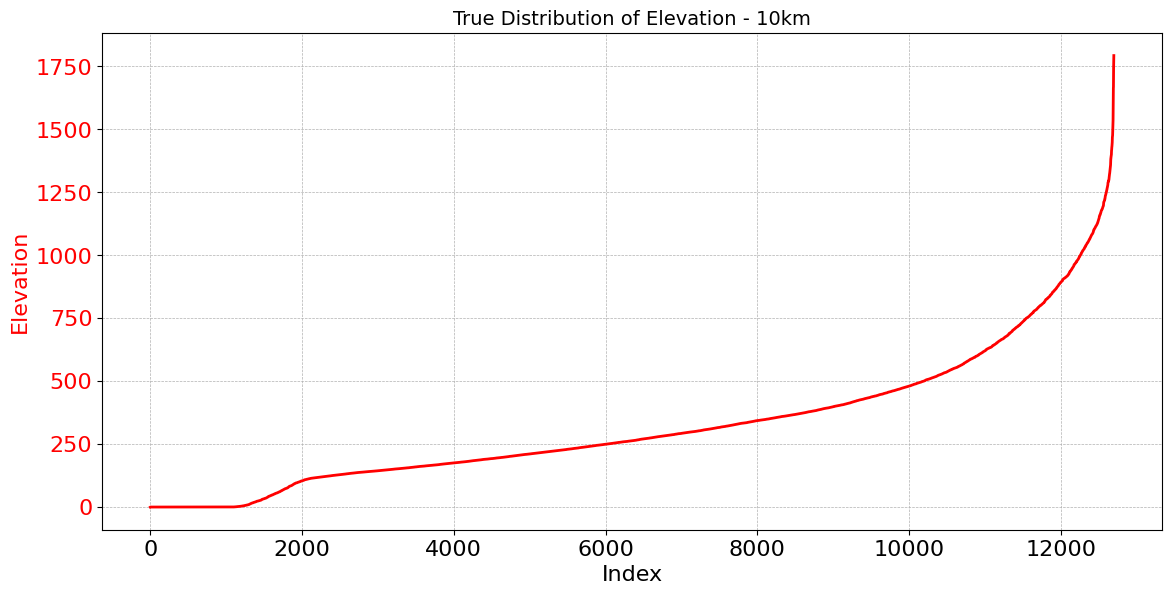

In [97]:
# get true distribution of elevation
elevations = list(data['elevation'])
elevations = sorted(elevations)

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

line_color = 'red'
ax1.set_xlabel('Index')
ax1.set_ylabel('Elevation', color=line_color)
ax1.plot([x for x in range(len(elevations))], elevations, color=line_color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=line_color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'True Distribution of Elevation - {resolution}', fontsize=14)
plt.show()